<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/CRISPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyTDC
!pip install lifelines

  Using cached lifelines-0.29.0-py3-none-any.whl (349 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached formulaic-1.0.2-py3-none-any.whl (94 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)


In [ ]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Leenay')

In [ ]:
from tdc.single_pred import CRISPROutcome
data = CRISPROutcome(name = 'Leenay', label_name=label_list[0])
split=data.get_split()

Downloading...
100%|██████████| 205k/205k [00:00<00:00, 317kiB/s]
Loading...
Done!


In [ ]:
split.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
split['train']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 1,CTGCAGGGCTAGTTTCCTATAGG,0.069572
1,GuideSeq 2,GAGATGCGGACCACCCAGCTGGG,0.287647
2,GuideSeq 3,GCAAACGGAAGTGCAATTGTCGG,0.137004
3,GuideSeq 4,GTCATCGCTGAGTTGAGGAAGGG,0.093889
4,GuideSeq 5,ATATGATTATCCCTGCACAAGGG,0.526525
...,...,...,...
1060,GuideSeq 1517,ATGCCCGACCAAAGACAACCAGG,0.093236
1061,GuideSeq 1518,CACGCTGTCATCCACCAGGTAGG,0.069054
1062,GuideSeq 1519,GGGCTCCAGAGTCTGATACAGGG,0.421439
1063,GuideSeq 1520,AAAGACTTCGGTCCTCTAGTAGG,0.206277


In [ ]:
split['train']['GuideSeq'].apply(len)

0       23
1       23
2       23
3       23
4       23
        ..
1060    23
1061    23
1062    23
1063    23
1064    23
Name: GuideSeq, Length: 1065, dtype: int64

<Axes: ylabel='Frequency'>

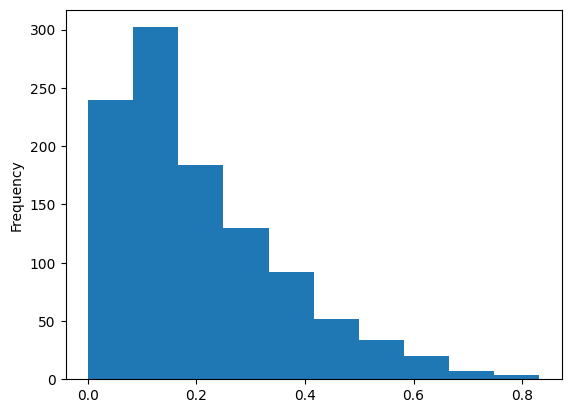

In [ ]:
split['train']['Y'].plot.hist()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

class SeqProcessor:
    def __init__(self, char, max_seq):
        # One-hot encoding에 사용할 character 정의
        self.char = char
        #  ㅒne-hot 인코더 fitting
        self.enc_dna = OneHotEncoder().fit(np.array(self.char).reshape(-1, 1))
        # Sequence 최대 길이
        self.max_seq = max_seq

    def trans_dna(self, x: str) -> list:
        """Protein sequence 데이터 전처리
        모든 sequence를 같은 크기의 리스트로 만들고
        사전 정의된 character에 해당 되지 않는 값은 ?로 변환한다.

        Args:
            x: A sequence
        """
        temp = list(x.upper()) # 대문자로 바꾸기
        temp = [i if i in self.char else '?' for i in temp] #

        if len(temp) < self.max_seq:
            # MAX_SEQ_DNA 보다 작으면 뒷부분을 ?로 채워서 MAX_SEQ_DRUG 길이의 리스트로 만들기
            temp = temp + ['?'] * (self.max_seq-len(temp))
        else:
            # MAX_SEQ_DNA 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
            temp = temp [:self.max_seq]

        return temp

    def dna_2_embed(self, x: list) -> np.ndarray:
        return self.enc_dna.transform(np.array(x).reshape(-1,1)).toarray().T


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Custom dataset 만들기

class data_process_loader(Dataset):
    def __init__(self, df: pd.DataFrame, sp: SeqProcessor):
        self.sp = sp
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        # Target 데이터
        v_s = self.df.iloc[index]['GuideSeq']
        v_s = self.sp.trans_dna(v_s)
        v_s = self.sp.dna_2_embed(v_s) # Target One-hot 인코딩 [26,100]

        # Binding affinity (label)
        y = self.df.iloc[index]['Y']

        return v_s, y


In [ ]:
dna_char=['?', 'A', 'T', 'G', 'C']
max_seq=23

sp = SeqProcessor(dna_char, max_seq)

In [ ]:
train_dataset = data_process_loader(split['train'], sp)
val_dataset = data_process_loader(split['valid'], sp)
test_dataset = data_process_loader(split['test'], sp)

In [ ]:
params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False}

In [ ]:
training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(val_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [ ]:
for (v_s, y) in training_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.0881, 0.1138, 0.0910, 0.0334, 0.0802, 0.4961, 0.0721, 0.2083, 0.1997,
        0.2950, 0.1544, 0.0587, 0.2838, 0.4350, 0.5068, 0.3089, 0.1501, 0.1028,
        0.1256, 0.4144, 0.1667, 0.2937, 0.5125, 0.3809, 0.0152, 0.1200, 0.0693,
        0.4678, 0.4701, 0.1018, 0.4065, 0.1637, 0.1730, 0.1094, 0.0696, 0.1572,
        0.1492, 0.1556, 0.0312, 0.0720, 0.2237, 0.0960, 0.1763, 0.3626, 0.4509,
        0.3952, 0.1364, 0.1521, 0.2181, 0.2928, 0.2929, 0.6091, 0.2338, 0.1357,
        0.2340, 0.5123, 0.0721, 0.0845, 0.1036, 0.0378, 0.2046, 0.1563, 0.4737,
        0.0809], dtype=torch.float64)


In [ ]:
# 모델 설정 값

config = {
    # dna embedding layer 설정
    "cnn_filters" : [32,64,96],
    "cnn_kernels" : [3,3,3],
    "hidden_dim" : 256,
    "rnn_hid_dim" : 64,
    "rnn_n_layers" : 2,
    "rnn_bidirectional" : True,
    "rnn_Use_GRU_LSTM" : 'GRU',

    # Classfier 설정
    "cls_hidden_dims" : [1024, 512]
    }

In [ ]:
class CNN_RNN(nn.Sequential):

    def __init__(self, **config):
        super(CNN_RNN, self).__init__()
        self.config = config
        """
        CNN 구현
        """
        # 레이어 별 CNN 필터 개수
        in_ch = [5] + config['cnn_filters']
        self.in_ch = in_ch[-1] # 마지막 convolution 층 필터 개수

        # 레이어 별 CNN kernel 사이즈
        kernels = config['cnn_kernels']

        # 전체 CNN Layer 개수
        layer_size = len(config['cnn_filters'])

        self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 수
                                                out_channels = in_ch[i+1], # output 채널 수
                                                kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
        self.conv = self.conv.double()

        # 마지막 층 사이즈 구하기
        n_size_d = self._get_conv_output((5, 23)) # auto get the seq_len of CNN output

        """
        RNN 구현 (LSTM / GRU)
        """
        if config['rnn_Use_GRU_LSTM'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature)
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM

        elif config['rnn_Use_GRU_LSTM'] == 'GRU':
            self.rnn = nn.GRU(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM
        else:
            raise AttributeError('Please use LSTM or GRU.')

        direction = 2 if config['rnn_bidirectional'] else 1
        self.rnn = self.rnn.double()

        # 마지막 drug 임베딩 층
        self.fc1 = nn.Linear(config['rnn_hid_dim'] * direction * n_size_d, config['hidden_dim'])

    def _get_conv_output(self, shape):

        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(bs, self.in_ch, -1).size(2)
        return n_size

    def _forward_features(self, x):
        for l in self.conv:
            x = F.relu(l(x))
        return x

    def forward(self, v):
        v = self._forward_features(v.double())

        batch_size = v.size(0)
        v = v.view(batch_size, v.size(2), -1)

        if self.config['rnn_Use_GRU_LSTM'] == 'LSTM':
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize hidden state
            c0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize cell state
            v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
        else:
            # GRU
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device)
            v, hn = self.rnn(v.double(), h0.double())

        v = torch.flatten(v, 1)
        v = self.fc1(v.float())
        return v

In [ ]:
class Classifier(nn.Sequential):
	"""
	임베딩 된 drug와 protein을 이용하여 classificaion
	"""
	def __init__(self, model_dna, **config):
		"""
		Args:
			model_drug: drug emedding 모델
			model_protein: protein emedding 모델
			config: 모델 설정 값
		"""
		super(Classifier, self).__init__()

		self.input_dim = config['hidden_dim'] # drug feature 사이즈

		self.model_dna = model_dna # drug 임베딩 모델

		self.dropout = nn.Dropout(0.1) # dropout 적용

		self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
		layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
		dims = [self.input_dim] + self.hidden_dims + [1] # ["합쳐진 feature 차원 (drug + protein), hidden1, hidden2, hidden3, 1 (output layer)]

		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers

	def forward(self, v_s):
		# Drug/protein 임베딩
		v_s = self.model_dna(v_s)

		for i, l in enumerate(self.predictor):
			if i == (len(self.predictor)-1):
				# If last layer,
				v_s = l(v_s)
			else:
				# If Not last layer, dropout과 ReLU 적용
				v_s = F.relu(self.dropout(l(v_s)))

		return v_s



In [ ]:
model_DNA = CNN_RNN(**config)

In [ ]:
model = Classifier(model_DNA, **config)

In [ ]:
model = model.to(device)

In [ ]:
learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 30

opt      = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.MSELoss()

In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

In [ ]:

loss_history = []

max_MSE = 10000


# Best 모델 초기화
model_max = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
    # Model training
    model.train()

    # Mini-batch 학습
    for i, (v_s, label) in enumerate(training_generator):
        # input data gpu에 올리기
        v_s = v_s.float().to(device)
        # forward-pass
        score = model(v_s)

        n = torch.squeeze(score, 1)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(n.float(), label.float().to(device))

        # 각 iteration 마다 loss 기록
        loss_history.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()

    # gradient tracking X
    with torch.set_grad_enabled(False):

        y_pred = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_s, label) in enumerate(valid_generator):
            # validation 입력 데이터 gpu에 올리기
            v_s = v_s.float().to(device)

            # forward-pass
            score = model(v_s)

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            logits = torch.squeeze(score).cpu().numpy()
            label_ids = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()

    # metric 계산
    mse = mean_squared_error(y_label, y_pred) # MSE
    r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
    p_val = pearsonr(y_label, y_pred)[1] # Pearson correlation p-value
    CI =  concordance_index(y_label, y_pred) # CI

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)

    # mse 기준으로 best model 업데이트
    if mse < max_MSE:
        # best model deepcopy
        model_max = copy.deepcopy(model)
        # max MSE 업데이트
        max_MSE = mse

    # 각 epoch 마다 결과 출력
    print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

--- Go for Training ---
Validation at Epoch 1 , MSE: 0.02581 , Pearson Correlation: 0.16866 with p-value: 3.78E-02 , Concordance Index: 0.57798
Validation at Epoch 2 , MSE: 0.02495 , Pearson Correlation: 0.10338 with p-value: 2.05E-01 , Concordance Index: 0.54609
Validation at Epoch 3 , MSE: 0.02497 , Pearson Correlation: 0.09935 with p-value: 2.23E-01 , Concordance Index: 0.50993
Validation at Epoch 4 , MSE: 0.02563 , Pearson Correlation: -0.0410 with p-value: 6.15E-01 , Concordance Index: 0.49381
Validation at Epoch 5 , MSE: 0.02557 , Pearson Correlation: -0.0403 with p-value: 6.21E-01 , Concordance Index: 0.47490
Validation at Epoch 6 , MSE: 0.02459 , Pearson Correlation: 0.18144 with p-value: 2.53E-02 , Concordance Index: 0.55942
Validation at Epoch 7 , MSE: 0.02469 , Pearson Correlation: 0.19553 with p-value: 1.58E-02 , Concordance Index: 0.55785
Validation at Epoch 8 , MSE: 0.02439 , Pearson Correlation: 0.27173 with p-value: 7.08E-04 , Concordance Index: 0.59532
Validation at Ep

In [ ]:
for i, (v_d, label) in enumerate(test_dataset):
    print(v_d)
    print(label)
    break

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]]
0.1766602192134107


In [ ]:
# 테스트 진행

y_pred = []
y_label = []

model.eval()
for i, (v_s, label) in enumerate(test_generator):
    # input data gpu에 올리기
    v_s = v_s.float().to(device)

    # forward-pass
    score = model(v_s)

    # 예측값 gradient graph detach -> cpu로 옮기기 -> numpy 형으로 변환
    logits = torch.squeeze(score).detach().cpu().numpy()

    # 참값 cpu로 옮기고 numpy 형으로 변환
    label_ids = label.cpu().numpy()

    # 예측값, 참값 기록
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

# metric 계산
mse = mean_squared_error(y_label, y_pred)
r2 = pearsonr(y_label, y_pred)[0]
p_val = pearsonr(y_label, y_pred)[1]
CI =  concordance_index(y_label, y_pred)

print('TestSet Performence Metric '+  ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
        + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

TestSet Performence Metric  , MSE: 0.00990 , Pearson Correlation: 0.76252 with p-value: 4.60E-59 , Concordance Index: 0.78228


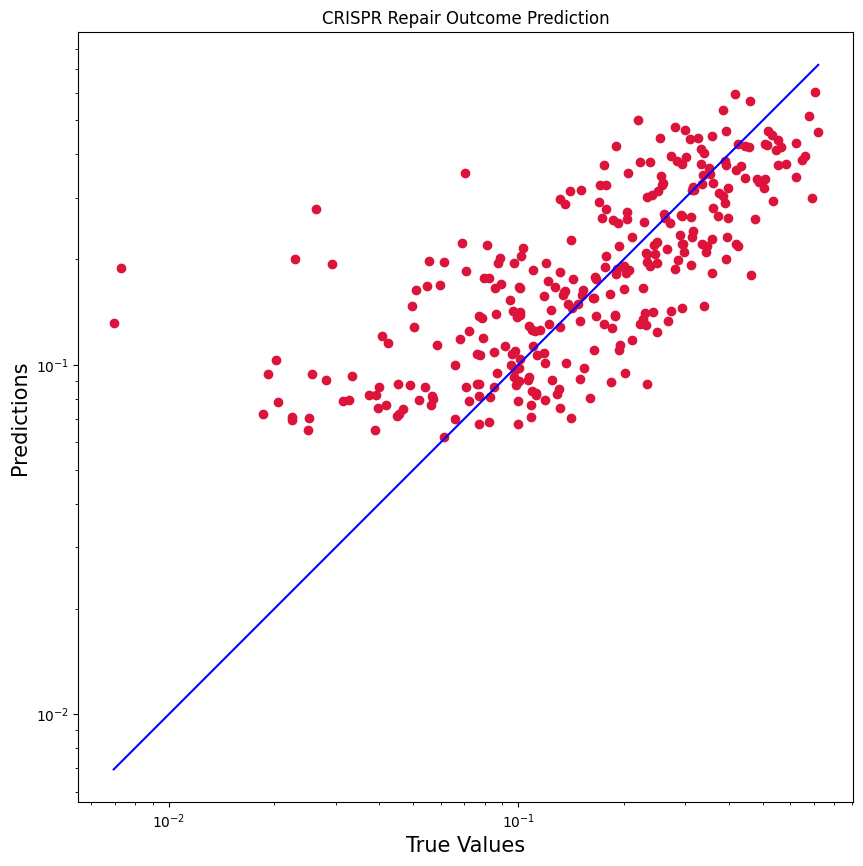

In [ ]:
# 최종 테스트 결과 시각화
import matplotlib.pyplot as plt

# 참값 ~ 예측값 scatter plot
plt.figure(figsize=(10,10))
plt.scatter(y_label, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_label))
p2 = min(min(y_pred), min(y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('CRISPR Repair Outcome Prediction')
plt.show()